In [1]:
###-----------------
### Import libraries
###-----------------
from pathlib import Path  # Import Path for file system path operations and management
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split  # Import function to split dataset into training and testing subsets
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             f1_score)  # Import function to calculate various metric


In [2]:
###------------------
### Global Parameters
###------------------

# Directories
#inpDir = '../../input' 
inpDir = Path('..') / '..' / 'input'
# outDir = '../output'
outDir = Path('..') / 'output'


RANDOM_STATE = 24 
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
rng = np.random.default_rng(seed = RANDOM_STATE)

TEST_SIZE  = 0.2 # Size of test data
NOISE = 0.2
EPOCHS = 50001
ALPHA = 0.1
N_SAMPLE  = 1000


# Parameters for plotting
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

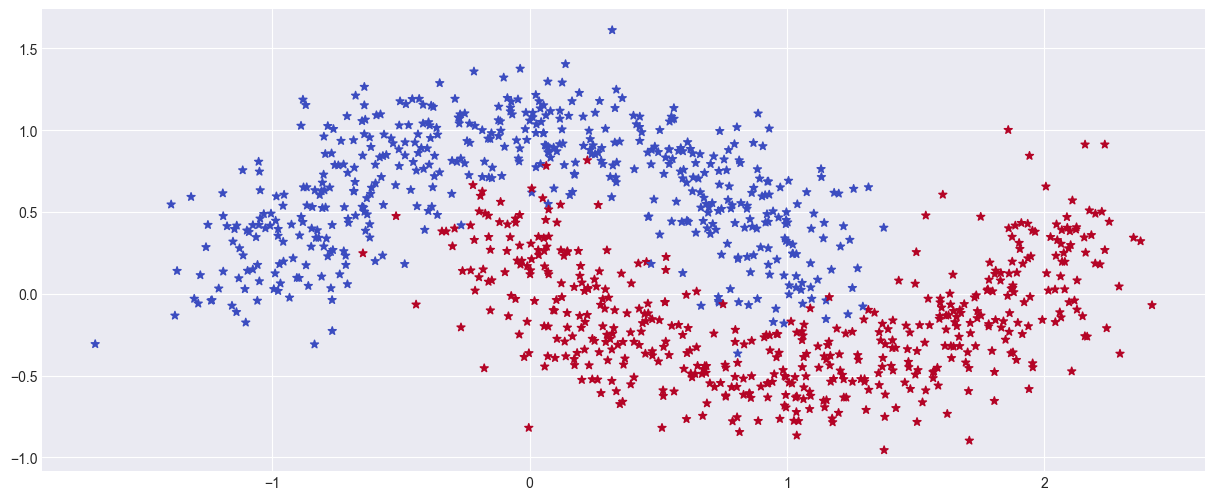

In [3]:
X,y  = make_moons(n_samples=N_SAMPLE,noise=NOISE,random_state=RANDOM_STATE,shuffle=True)


plt.scatter(X[:,0],X[:,1],c=y,cmap= CMAP,marker='*')

In [26]:
def fn_plot_decision_boundary(X: np.ndarray,y: np.ndarray, model:dict, predict):
    """
    Plots the decision boundary for a classification model along with the data points.
    
    Args:
        X (np.ndarray): Input feature matrix with shape (n_samples, 3)
        wts (np.ndarray): Weights matrix
        pred_function: Function to predict using weights and datapoints
    """
    
    # Initialize the figure with specified dimensions
    fig, ax = plt.subplots( figsize=(8, 5) )
    
    # Small increment value to create a fine grid for smooth decision boundary
    dm = 0.05
    padding = 2 * dm
    
    # Calculate the range for x-axis (first feature) with padding
    x_min, x_max = X[:, 0].min() - padding, X[:, 0].max() + padding
    
    # Calculate the range for y-axis (second feature) with padding  
    y_min, y_max = X[:, 1].min() - padding, X[:, 1].max() + padding
    
    # Create a mesh grid covering the entire feature space
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))
    
    # Flatten the mesh grid arrays and stack them column-wise to create coordinate pairs
    XX = np.c_[xx.ravel(), yy.ravel()] # Resulting shape: (n_points, 2)

    # Add a column of ones to the coordinate array for the bias term
    
    # List to collect predictions for each point in the mesh grid
    y_pred = predict(model,XX)
    Z = np.array(y_pred).reshape(xx.shape)
    # Create filled contour plot showing the decision regions
    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    
    # Scatter plot of the actual data points, colored by their true class labels
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.bwr)
    
    # Set plot title and axis labels
    ax.set_title('Decision Boundary')
    ax.set_xlabel('A')  
    ax.set_ylabel('B') 
    
    # Display the final plot
    plt.show()

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=TEST_SIZE,random_state=RANDOM_STATE)
y_train = y_train.reshape(-1,1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((800, 2), (200, 2), (800, 1), (200,))

In [5]:
data_df = pd.DataFrame(X,columns=['A','B'])
data_df['target'] = y
data_df

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0
...,...,...,...
995,-1.005476,0.490728,0
996,-0.484457,0.846436,0
997,0.284856,0.793560,0
998,1.712514,-0.177786,1


In [6]:
data_train,data_test  = data_df.to_numpy()[:900],data_df.to_numpy()[900:]
data_train.shape,data_test.shape

((900, 3), (100, 3))

In [7]:
def fn_sigmoid(z: np.ndarray) -> float:
    return 1 / (1 + np.exp(-z))

In [8]:
def fn_active(z):
    return np.tanh(z)
def fn_active_prime(z):
    return 1.0 - np.tanh(z)**2

In [9]:
fn_active(np.asarray([[-1.0,0,1.0]]))

array([[-0.76159416,  0.        ,  0.76159416]])

In [10]:
		
def predict(model, X):
    W1 = model['W1']
    W2 = model['W2']
    b1 = model['b1']
    b2 = model['b2']
    
    #Forward propgation - 
    z1 = X.dot(W1) + b1 #aggregation
    a1 = fn_active(z1) #activation
    z2 = a1.dot(W2) + b2
    a2 = fn_sigmoid(z2)
    return a2 >= 0.5


In [11]:
		
def calculate_loss(model, X,y):
    W1 = model['W1']
    W2 = model['W2']
    b1 = model['b1']
    b2 = model['b2']
    m = X.shape[0]
    #Forward propgation - 
    z1 = X.dot(W1) + b1 #aggregation
    a1 = fn_active(z1) #activation
    z2 = a1.dot(W2) + b2
    a2 = fn_sigmoid(z2)
    data_loss = -(y * np.log(a2) + (1-y)*np.log(1-a2)).sum()
    return data_loss/m

In [12]:
    
loss_hist = {}

def build_model(nn_hdim,X,y,alpha,n_epoch):
    m,nn_input_dim = X.shape
    nn_output_dim = y.shape[1]
    W1 = rng.random((nn_input_dim,nn_hdim)) / np.sqrt(nn_input_dim) #initialize random weights 
    W2 = rng.random((nn_hdim,nn_output_dim)) / np.sqrt(nn_hdim) #initialize random weights 
    b1 = np.zeros((1,nn_hdim))
    b2 = np.zeros((1,nn_output_dim))

    loss,epoch = [],[]
    
    for i in range(n_epoch):
        #Forward propgation - 
        z1 = X.dot(W1) + b1 #aggregation
        a1 = fn_active(z1) #activation

        z2 = a1.dot(W2) + b2
        a2 = fn_sigmoid(z2)
        
        
        #Back propogation - 
        
        #layer 2
        dz2 = a2 - y
        assert(z2.shape == dz2.shape), f'Shape z2, {z2.shape} , {dz2.shape}'
        dW2 = (a1.T).dot(dz2)
        assert(W2.shape == dW2.shape), f'Shape z2, {W2.shape} , {dW2.shape}'
        db2 = np.sum(dz2,axis = 0,keepdims=True)
        assert(b2.shape == db2.shape), f'Shape z2, {b2.shape} , {db2.shape}'
        da1 = dz2.dot(W2.T)
        assert(a1.shape == da1.shape), f'Shape z2, {a1.shape} , {da1.shape}'

        #layer 1
        dz1 = da1 * fn_active_prime(z1)
        assert(z1.shape == dz1.shape), f'Shape z2, {z1.shape} , {dz1.shape}'
        dW1 = (X.T).dot(dz1)
        assert(W1.shape == dW1.shape), f'Shape z2, {W1.shape} , {dW1.shape}'
        db1 = np.sum(dz1,axis = 0,keepdims=True)
        assert(b1.shape == db1.shape), f'Shape z2, {b1.shape} , {db1.shape}'

        #upldating wieghts and bias for optimization
        W1 = W1 - alpha*dW1/m
        W2 = W2 - alpha*dW2/m
        b1 = b1 - alpha*db1/m
        b2 = b2 - alpha*db2/m

        
        model = {'W1' : W1,'W2' : W2, 'b1' : b1, 'b2' : b2}
        if  i%100 == 0:
            curr_loss = calculate_loss(model,X,y)
            epoch.append(i)
            loss.append(curr_loss)
            print(f'epoch - {i} : Loss - {curr_loss}')
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    return model

In [44]:
model = build_model(100,X_train,y_train,ALPHA,EPOCHS)
# y_train = y_train.reshape(-1,1)
# y_train.shape
model

epoch - 0 : Loss - 0.8195196762311326
epoch - 100 : Loss - 0.3108286241528225
epoch - 200 : Loss - 0.2971407524699585
epoch - 300 : Loss - 0.2926502582086466
epoch - 400 : Loss - 0.2891606864761961
epoch - 500 : Loss - 0.2858248934367196
epoch - 600 : Loss - 0.28237464504829707
epoch - 700 : Loss - 0.27858070467695567
epoch - 800 : Loss - 0.27418799312564274
epoch - 900 : Loss - 0.26890054160027904
epoch - 1000 : Loss - 0.2623841074464067
epoch - 1100 : Loss - 0.2542971216257542
epoch - 1200 : Loss - 0.24436645550372307
epoch - 1300 : Loss - 0.23250911828184886
epoch - 1400 : Loss - 0.2189567684347117
epoch - 1500 : Loss - 0.20429294699397013
epoch - 1600 : Loss - 0.18933399181303934
epoch - 1700 : Loss - 0.17489725351655136
epoch - 1800 : Loss - 0.16159434971966202
epoch - 1900 : Loss - 0.14975087713600677
epoch - 2000 : Loss - 0.13944431129948437
epoch - 2100 : Loss - 0.13059189531960377
epoch - 2200 : Loss - 0.12303280075073948
epoch - 2300 : Loss - 0.11658356871530318
epoch - 2400 

{'W1': array([[-2.93001880e-01, -5.40064588e-01,  1.07336202e+00,
          8.19686314e-01,  6.13161452e-01,  4.53027049e-01,
          5.28332529e-01,  5.31464289e-01,  5.28333756e-01,
          3.04737528e+00,  4.54901441e-01, -6.55754674e-01,
         -5.49332186e-01,  4.54989196e-01,  3.77836585e-01,
          3.26585963e-01, -6.11078014e-01, -3.97401579e-01,
          6.27912011e-01, -5.20479741e-01,  4.57781015e-01,
          4.43893109e-01, -5.16753211e-01,  7.47930621e-01,
          5.14301089e-01,  4.54754407e-01,  5.61665758e-01,
          4.34403692e-01,  5.70733469e-01,  4.57496424e-01,
          3.49872086e+00,  4.21259115e-01,  7.67428146e-01,
         -4.68300534e-01,  2.96036862e+00,  4.67218441e-01,
         -6.03124686e-01,  5.03854482e-01,  4.65295038e-01,
          8.30367569e-01,  2.98897940e+00,  5.33143501e-01,
          2.61667310e-01,  4.32424468e-01,  4.52551622e-01,
          4.94263338e-01,  6.45826991e-01, -5.31806647e-01,
          6.06134427e-01,  4.36300

In [48]:
loss_df = pd.DataFrame(loss_hist)
loss_df

,epoch,loss
0,0,0.819520
1,100,0.310829
2,200,0.297141
3,300,0.292650
4,400,0.289161
...,...,...
496,49600,0.051617
497,49700,0.051609
498,49800,0.051601
499,49900,0.051593


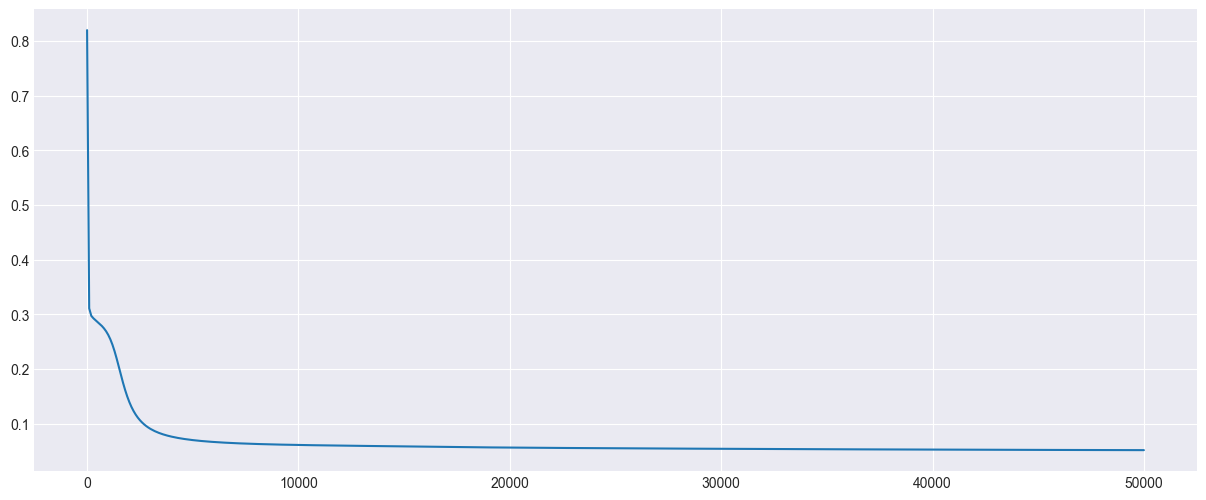

In [46]:
plt.plot(loss_df['epoch'],loss_hist['loss'])

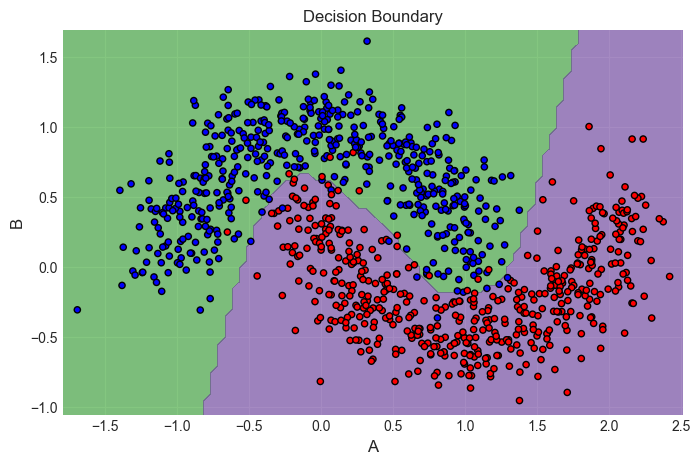

In [47]:
fn_plot_decision_boundary(X,y,model,predict)